<a href="https://colab.research.google.com/github/MECAI2022/short_text_classification/blob/main/Pre_treatment_lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **LightGBM**

In [18]:
 !nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [19]:
#!pip install fasttext

!pip uninstall -y lightgbm

# After running
! git clone --recursive https://github.com/Microsoft/LightGBM

#You can run this oneliner which will build and compile LightGBM with GPU enabled in colab:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;    

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Cloning into 'LightGBM'...
remote: Enumerating objects: 27883, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 27883 (delta 83), reused 127 (delta 62), pack-reused 27713
Receiving objects: 100% (27883/27883), 19.82 MiB | 34.88 MiB/s, done.
Resolving deltas: 100% (20635/20635), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...

In [16]:
import lightgbm as LGBM
import re
import nltk
from sklearn import feature_extraction, manifold
import re
import os
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from unicodedata import normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [4]:
LGBM.__version__

'3.3.2.99'

In [2]:
def remover_acentos(txt):
    try:
        return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')
    except:
        return np.nan


In [3]:
filepath = "/content/drive/MyDrive/dataset_produtos.xlsx"
filesave = "/content/drive/MyDrive/"


df = pd.read_excel(filepath)

df = df[df['nm_item'].str.lower()!='nao cadastrado'].reset_index(drop=True)
print(df.columns)

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Index(['nm_item', 'segmento', 'categoria', 'subcategoria', 'nm_product'], dtype='object')


In [4]:
def convert_case(match_obj):
  if match_obj.group(1) is not None:
      match_obj.group(1).replace(' ','')

#Palavras todas minusculas

df['nm_item'] = df['nm_item'].str.lower()

#Remover acentos
df['nm_item2'] = df['nm_item'].apply(remover_acentos)
print('Palavras com acento: ' + str((df['nm_item2']!=df['nm_item']).sum()))

#Remover pontuação
df['nm_item3'] = df['nm_item2'].replace(r'[^\w\s]', ' ',regex=True)
print('Palavras com pontuação: ' + str((df['nm_item3']!=df['nm_item2']).sum()))

# Remover multiplos espaços
df['nm_item4'] = df['nm_item3'].replace(r'\s+', ' ',regex=True)
print('Palavras multiplos espaços: ' + str((df['nm_item4']!=df['nm_item3']).sum()))

#ajustar unidades e dimensao

df['UN_DIM'] = df['nm_item4'].str.extract(r'(\d+kg|\d+mg|\d+ml|\d+km|\d+cm|\d+meia|\d+w[\s\S]*?|\d+v[\s\S]*?|\d+g[\s\S]*?|\d+k[\s\S]*?|\d+l[\s\S]*?|\d+\s+g[\s\S]*?|\d+\s+k[\s\S]*?|\d+\s+kg|\d+\s+mg|\d+\s+ml|\d+\s+meia|\d+\s+km|\d+\s+cm|\d+\s+m[\s\S]*?|\d+\s+v[\s\S]*?|\d+\s+w[\s\S]*?)')
df['UN_DIM2'] = df['nm_item4'].str.extract(r'[\s\S]*?(\bkg)')

df['UN_DIM'] = df['UN_DIM'].fillna(df['UN_DIM2'])

df['VALOR'] = df['UN_DIM'].str.extract(r'(\d+)')
df['UNIDADE'] = df['UN_DIM'].str.extract(r'(\D+)')

df['VALOR'] = df['VALOR'].str.replace(' ','')
df['UNIDADE'] = df['UNIDADE'].str.replace(' ','')

print(len(df))

df_meia = df[df['UNIDADE']=='meia'].reset_index(drop=True)

df_n = df[df['UNIDADE']!='meia'].reset_index(drop=True)

df_meia['UN_DIM2'] = df_meia['nm_item4'].str.extract(r'(\d+kg|\d+mg|\d+ml|\d+km|\d+cm|\d+w[\s\S]*?|\d+v[\s\S]*?|\d+g[\s\S]*?|\d+k[\s\S]*?|\d+l[\s\S]*?|\d+\s+g[\s\S]*?|\d+\s+k[\s\S]*?|\d+\s+kg|\d+\s+mg|\d+\s+ml|\d+\s+km|\d+\s+cm|\d+\s+v[\s\S]*?|\d+\s+w[\s\S]*?)')

df_meia['UN_DIM2'] = df_meia['UN_DIM2'].fillna('meia')

df_meia['VALOR'] = df_meia['UN_DIM2'].str.extract(r'(\d+)')
df_meia['UNIDADE'] = df_meia['UN_DIM2'].str.extract(r'(\D+)')

df_meia['VALOR'] = df_meia['VALOR'].str.replace(' ','')
df_meia['UNIDADE'] = df_meia['UNIDADE'].str.replace(' ','')

df = pd.concat([df_n,df_meia],ignore_index=True)

df['VALOR'] = np.where(df['VALOR'].astype(float)>10000,np.nan,df['VALOR'])

df['UNIDADE2'] = np.where((df['VALOR'].astype(float)<2)&(df['UNIDADE']=='k'),'kg',df['UNIDADE'])

df['VALOR'] = df['VALOR'].fillna('')

df['UN_DIM2'] = np.where((df['VALOR'].isnull())&(df['UNIDADE2']!='meia'),' '+'1'+df['UNIDADE2'].astype(str)+' ',' '+df['VALOR'].astype(str) + df['UNIDADE2'].astype(str)+ ' ')


df['nm_item5'] = df[['nm_item4','UN_DIM','UN_DIM2']].apply(lambda x : x[0].replace(str(x[1]),str(x[2])),axis=1)

# Remover multiplos espaços
df['nm_item6'] = df['nm_item5'].replace(r'\s+', ' ',regex=True)
print('Palavras multiplos espaços: ' + str((df['nm_item6']!=df['nm_item5']).sum()))

# Remover caracteres unicos
df['nm_item7'] = df['nm_item6'].replace(r'\b\D\s\b', '',regex=True)
print('Caracteres únicos: ' + str((df['nm_item7']!=df['nm_item6']).sum()))

df = df.drop(['nm_item2','nm_item3','nm_item5','nm_item6','UN_DIM2','UNIDADE','UN_DIM'],axis=1)


df['UNIDADE2'] = np.where(df['UNIDADE2']=='meia',np.nan,df['UNIDADE2'])

print(len(df))

df['VALOR'] = df['VALOR'].replace('',np.nan)


Palavras com acento: 60
Palavras com pontuação: 37392
Palavras multiplos espaços: 23178
158037
Palavras multiplos espaços: 134506
Caracteres únicos: 26162
158037


In [17]:
df2 = df['UNIDADE2'].fillna('NA')

plt.title('Distribuição por unidade de medidas')
sns.countplot(x = df2)

del df2
del df_meia
del df_n

gc.collect()

555

In [6]:
def utils_preprocess_text(text, flg_stemm=True, flg_lemm=False, lst_stopwords=None):

    lst_text = text.split(' ')
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [7]:
lst_stopwords = nltk.corpus.stopwords.words("portuguese")
print(lst_stopwords)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

In [8]:
df["nm_item7"] = df["nm_item7"].apply(lambda x: utils_preprocess_text(x, flg_stemm=True, flg_lemm=False, lst_stopwords = lst_stopwords ))

# Remover caracteres unicos
df['texto_treino'] = df['nm_item7'].replace(r'\b\D\s\b', '',regex=True)
print('Caracteres únicos: ' + str((df['nm_item7']!=df['texto_treino']).sum()))


Caracteres únicos: 0


In [8]:
df[df['nm_item']!=df['texto_treino']][['nm_item','texto_treino']]

,nm_item,texto_treino
0,apresuntado rezende pec kg,apresuntado rezend pec kg
1,carne suin espinhaco kg,carn suin espinhaco kg
2,whisky white 1lhorse trad.,whiski white 1l hors trad
3,whisky johnn walker 1l unred label.,whiski johnn walker 1l unr label
4,lte cond mocasemi desn tp 395g.,lte cond mocasemi desn tp 395g
...,...,...
158032,kit 3 meias invis rp 00421058 sort,kit meia invi rp 00421058 sort
158033,kit 3 meias invis rp 00421056 pto,kit meia invi rp 00421056 pto
158034,kit 3 meias rp fem lg est,kit meia rp fem lg est
158035,kit 3 meias rp fem lg lisa,kit meia rp fem lg lisa


In [9]:
df['word_count'] = df["texto_treino"].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df["texto_treino"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['sentence_count'] = df["texto_treino"].apply(lambda x: len(str(x).split(".")))
df['avg_word_length'] = df['char_count'] / df['word_count']
df['avg_sentence_lenght'] = df['word_count'] / df['sentence_count']
df['VALOR'] = df['VALOR'].astype(float)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

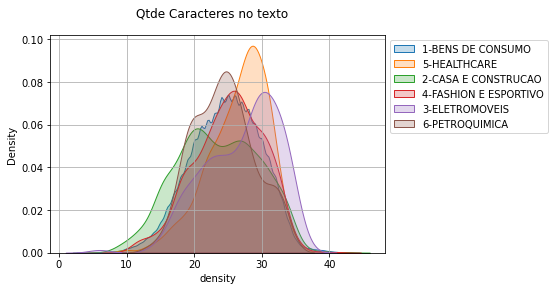

In [14]:
x, y = "char_count", "segmento"
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle('Qtde Caracteres no texto', fontsize=12)
for i in df[y].unique():
    # sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
    #              bins=10, hist_kws={"alpha":0.8}, 
    #              axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax)
ax.grid(True)
ax.legend(df[y].unique())
ax.grid(True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

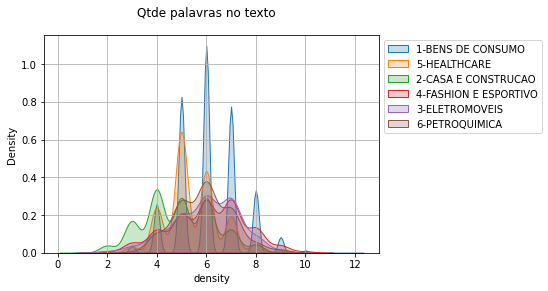

In [29]:
x, y = "word_count", "segmento"
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle('Qtde palavras no texto', fontsize=12)
for i in df[y].unique():
    # sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
    #              bins=10, hist_kws={"alpha":0.8}, 
    #              axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax)
ax.grid(True)
ax.legend(df[y].unique())
ax.grid(True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

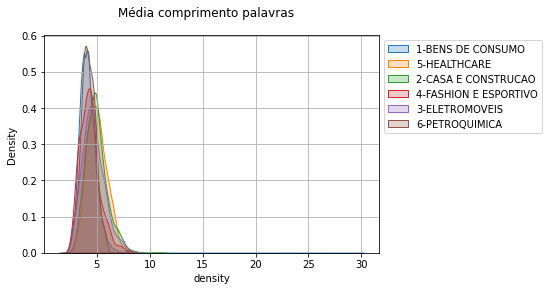

In [30]:
x, y = "avg_word_length", "segmento"
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle('Média comprimento palavras', fontsize=12)
for i in df[y].unique():
    # sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
    #              bins=10, hist_kws={"alpha":0.8}, 
    #              axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax)
ax.grid(True)
ax.legend(df[y].unique())
ax.grid(True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

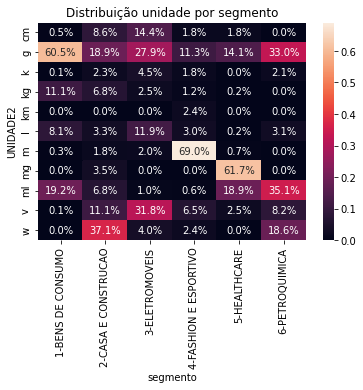

In [31]:
x, y = "UNIDADE2", "segmento"

base1= pd.crosstab(df['UNIDADE2'],df['segmento']).astype(float)

base1 = (base1/base1.sum()).round(3)

plt.title('Distribuição unidade por segmento')
sns.heatmap(base1,annot=True,fmt = ".1%")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

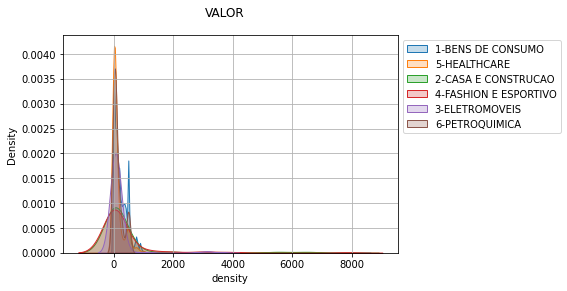

In [32]:
x, y = "VALOR", "segmento"
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle(x, fontsize=12)
for i in df[y].unique():
    # sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
    #              bins=10, hist_kws={"alpha":0.8}, 
    #              axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax)
ax.grid(True)
ax.legend(df[y].unique())
ax.grid(True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

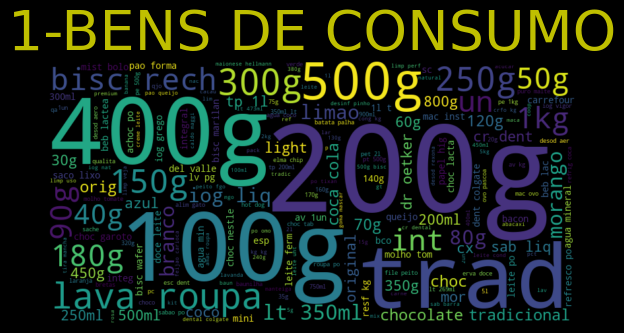

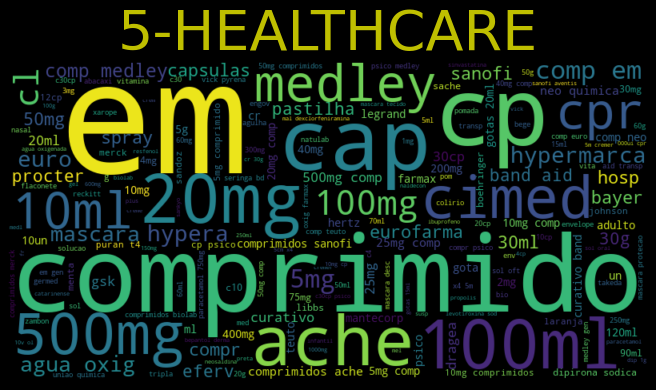

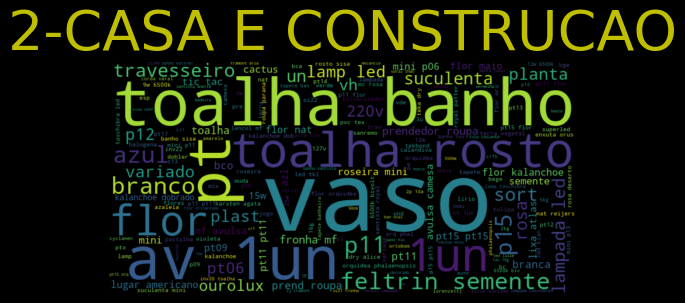

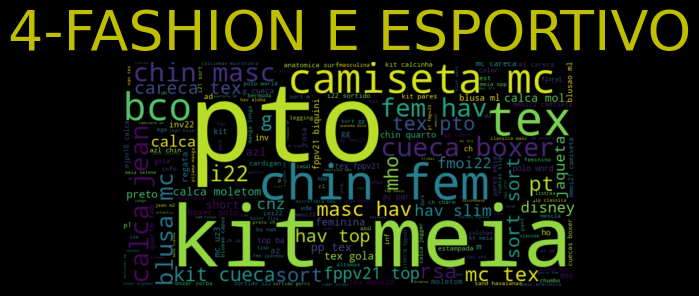

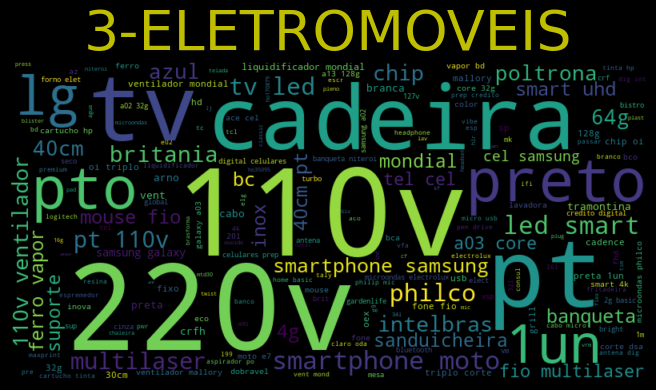

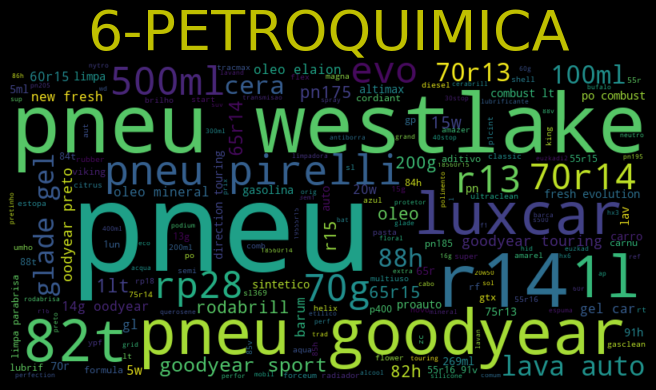

In [29]:
from wordcloud import WordCloud
import matplotlib as mpl

def cloud(text, title, size=(8,8)):
    """
    Function to plot WordCloud
    Includes: 
    """
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=100
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    # Redundant when combined with my Preprocessing function
    wordcloud = WordCloud(width=800, height=400,
                          background_color='black',
                         ).generate(str(text))
    
   # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()


for y in df['segmento'].unique():

    word = df[df['segmento']==y].reset_index(drop=True)

    word = word['texto_treino'] + ' '

    word_final = word.sum()

    cloud(word_final, title="{}".format(y))



In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

# Machine learning e metricas
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

import itertools
from zipfile import ZipFile

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

In [11]:
glove_filename='glove_s50'

In [12]:
docs = [x.split() for x in df['texto_treino']]
docs_dict = Dictionary(docs)
docs_dict.filter_extremes(no_below=15, no_above=0.005)
docs_dict.compactify()

In [13]:
len(docs_dict)

4918

In [14]:
docs_corpus = [docs_dict.doc2bow(doc) for doc in docs]
model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
docs_tfidf  = model_tfidf[docs_corpus]
docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])


In [15]:
with ZipFile(os.path.join(filesave,glove_filename+'.zip')) as zf:
        with zf.open(glove_filename+'.txt') as f:

          model = KeyedVectors.load_word2vec_format(f, binary=False)

In [26]:
tfidf_emb_vecs=np.zeros((len(docs_dict),50))
emp_words = 0
for i in range(len(docs_dict)):

  try:

    emb = model.get_vector(docs_dict[i])

    tfidf_emb_vecs[i] = emb
  
  except:
    emp_words += 1


print("Number of samples with no words found: %s / %s" % (emp_words, len(docs_dict)))

#tfidf_emb_vecs = np.vstack([model.get_vector(docs_dict[i]) for i in range(len(docs_dict))])

Number of samples with no words found: 1531 / 4918


In [27]:
print(tfidf_emb_vecs.shape)
print(docs_vecs.shape)

(4918, 50)
(158037, 4918)


In [28]:
docs_emb = np.dot(docs_vecs, tfidf_emb_vecs) 

In [29]:
del docs_vecs
del tfidf_emb_vecs
del model

gc.collect()

899

In [31]:
# One hot
df['UNIDADE2'] = df['UNIDADE2'].fillna('NA')
df['VALOR'] = df['VALOR'].astype(float)

drop_enc = OneHotEncoder(drop='first',sparse=False)

drop_enc.fit(df[['UNIDADE2']])

cols_hot = drop_enc.transform(df[['UNIDADE2']])

cols_hot = pd.DataFrame(data = cols_hot,columns = drop_enc.get_feature_names_out())

In [19]:
cols_hot

,UNIDADE2_cm,UNIDADE2_g,UNIDADE2_k,UNIDADE2_kg,UNIDADE2_km,UNIDADE2_l,UNIDADE2_m,UNIDADE2_mg,UNIDADE2_ml,UNIDADE2_v,UNIDADE2_w
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
158032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
X_vec = pd.DataFrame(data=docs_emb,columns=range(1,docs_emb.shape[1]+1))

In [33]:
X_FINAL = pd.concat([X_vec,cols_hot,df[['VALOR','word_count','char_count','avg_word_length']]],axis=1)

le = preprocessing.LabelEncoder()

df['segmento'] = le.fit_transform(df['segmento'])

In [ ]:
def learning_rate_power_0997(current_iter):
    base_learning_rate = 0.1
    min_learning_rate = 0.02
    lr = base_learning_rate  * np.power(.995, current_iter)
    return max(lr, min_learning_rate) 

#fit_params['callbacks'] = [lgb.reset_parameter(learning_rate=learning_rate_power_0997)]

In [ ]:
Xtr, Xtest, ytr, ytest = train_test_split(X_FINAL, df['segmento'], train_size=0.7, random_state = 0, stratify=df['segmento'])

Xtr = Xtr.reset_index(drop=True)
Xtest = Xtest.reset_index(drop=True)
ytr = ytr.reset_index(drop=True)
ytest = ytest.reset_index(drop=True)

K=5

kfold = StratifiedKFold(n_splits = K, 
                            random_state = 231, 
                            shuffle = True) 

model_dict={
            'LGBM':{'learning_rate':[0.01], 
                     'objective':['multiclass'],
                     'num_class': [len(df['segmento'].unique())],
                     'max_depth':[-1],
                     'num_leaves':[5,10,20], 
                     'min_data_in_leaf':[10,50,90],
                     'is_unbalance':[True], 
                    #  'feature_fraction':[0.2,0.3,0.6,0.8], 
                    #  'bagging_fraction':[0.05,0.1,0.5,0.8], 
                     'verbosity':[-1],
                     'metric':['auc_mu'],
                     'seed':[1],
                    "boosting_type": ["gbdt"],
                     'device_type' : ['cpu'],
                    # "gpu_platform_id": [0],
                    # "gpu_device_id": [0]

                   },
    
                     }
final_results = pd.DataFrame()
metrics = np.zeros((1,K)) 
for model in model_dict.keys():
    
    for p in itertools.product(*model_dict[model].values()):
        
        model_=eval(model)

        parameters=dict(zip(model_dict[model].keys(),p))

        if model != 'LGBM' and model !='NN': 

            model_=model_(**parameters)

        lr_probs_test = 0

        for i, (f_ind, outf_ind) in enumerate(kfold.split(Xtr, ytr)):
            
            X_train=Xtr.loc[f_ind]
            y_train=ytr.loc[f_ind]


            X_val=Xtr.loc[outf_ind]
            y_val=ytr.loc[outf_ind]
            
            if model =='LGBM':
                
                d_tr, d_valid = train_test_split(X_train.index,
                                                    test_size=.3,random_state=3)


                Xt2,Xv2,yt2,yv2=(X_train.loc[d_tr],
                            X_train.loc[d_valid],
                            y_train.loc[d_tr],
                            y_train.loc[d_valid])
                             
                d_train = LGBM.Dataset(Xt2, label = yt2, 

                                      )

                d_val = LGBM.Dataset(Xv2, label = yv2, 
                                    )

                in_list=['num_boost_round']

                parameters_in={x:parameters[x] for x in parameters if x in in_list }

                parameters_out={x:parameters[x] for x in parameters if x not in in_list }


                model_t=model_.train(parameters_out,train_set=d_train,
                              valid_sets =[d_train,d_val],callbacks=[LGBM.early_stopping(stopping_rounds=800),LGBM.log_evaluation(200)],
                              num_boost_round=80000)

                lr_probs_test += model_t.predict(Xtest)

                lr_probs = model_t.predict(X_val)

                #lr_probs_t = model_t.predict(X_train)

                metrics[0,i] = roc_auc_score(y_val,lr_probs,average='macro',multi_class='ovr')

                #metrics[1,i] = roc_auc_score(y_train,lr_probs_t,average='macro')

        means = metrics.mean(1)
        deviation = metrics.std(1,ddof=1)
        print('roc_auc_val: %.4f' %(means[0]))

        lr_probs_test = lr_probs_test/K

        y_pred = np.argmax(lr_probs_test,axis=1)


        dict_scores = classification_report(ytest,y_pred, 
                          labels=le.transform(le.classes_) ,target_names=le.classes_,
                          output_dict=True,
                          digits=4)
        
        auc_test = roc_auc_score(ytest,lr_probs_test,average='macro',multi_class='ovr')
        
        print('roc_auc_test: %.4f' %(auc_test))
        print('f1-score_test: %.4f' %(dict_scores['macro avg']['f1-score']))

        results=pd.DataFrame([{'Model':model,
                              'parameters':parameters,
                              'roc_auc':means[0],
                              'roc_auc_std':deviation[0],
                              #'roc_auc_train':means[2],
                               'roc_auc_test':auc_test,
                               'f1-score':dict_scores['macro avg']['f1-score'],
                               'recall':dict_scores['macro avg']['recall'],
                               'precision':dict_scores['macro avg']['precision']
                              }])

        final_results=final_results.append(results,ignore_index=True)

        final_results.to_csv(os.path.join(filesave,"LGBM_PARAMETERS.csv"),sep=';',decimal=',',encoding='utf-8',
                      index=False)


Training until validation scores don't improve for 800 rounds
[200]	training's auc_mu: 0.978254	valid_1's auc_mu: 0.948101
[400]	training's auc_mu: 0.9883	valid_1's auc_mu: 0.960552
[600]	training's auc_mu: 0.992554	valid_1's auc_mu: 0.964758
[800]	training's auc_mu: 0.994875	valid_1's auc_mu: 0.966729
[1000]	training's auc_mu: 0.996215	valid_1's auc_mu: 0.968256
[1200]	training's auc_mu: 0.997026	valid_1's auc_mu: 0.969379
[1400]	training's auc_mu: 0.997608	valid_1's auc_mu: 0.970071
[1600]	training's auc_mu: 0.998032	valid_1's auc_mu: 0.970841
[1800]	training's auc_mu: 0.99837	valid_1's auc_mu: 0.971184
[2000]	training's auc_mu: 0.998641	valid_1's auc_mu: 0.971755
[2200]	training's auc_mu: 0.998834	valid_1's auc_mu: 0.972218
[2400]	training's auc_mu: 0.999043	valid_1's auc_mu: 0.972692
[2600]	training's auc_mu: 0.999192	valid_1's auc_mu: 0.973226
[2800]	training's auc_mu: 0.999306	valid_1's auc_mu: 0.973452
[3000]	training's auc_mu: 0.999413	valid_1's auc_mu: 0.974039
[3200]	training